# Data Analytics Of Compensatory Movements In PROM Assisted Stroke Rehabilitation Using Kinect Pose Data

KIE4033 Data Analytics Assignment
By: Khoo Joe Vey 22004672
Supervised by: Associate Prof IR Dr Chow Chee Onn

This notebook presents an end-to-end data analytics pipeline for analyzinb rehabilitation movements using the **Toronto Rehab Stroke Pose Dataset (TRSP)**. The study is conducted in support of the Integrated Design Project (IDP) titled **“AI Assisted Passive Range of Motion (PROM) Device for Acute and Sub-acute Stroke Patients.”**

The dataset consists of three-dimensional joint kinematics captured using a Kinect-based motion tracking system during robot-assisted rehabilitation tasks. Each frame is represented by 25 skeletal joints with Cartesian coordinates, resulting in a 75-dimensional feature vector per frame.

The primary objective of this analysis is to investigate whether compensatory movement patterns—known to reduce therapeutic effectiveness—can be automatically characterized and detected using data-driven meevelopment, evaluation, and interpretation.


In [12]:
# General Imports
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

%pip install -q scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_curve,
    classification_report,
    precision_recall_curve,
    auc,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    silhouette_score,
    balanced_accuracy_score
)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Note: you may need to restart the kernel to use updated packages.


## Loading Data

The following cell follows the original loading logic:
- Iterate over subject folders (Hxx for healthy, Pxx for patients)
- Iterate over task folders per subject
- Convert `Joint_Positions.csv` (25 rows per frame) into a `(n_frames, 75)` feature matrix
- Load `Labels.csv` and verify length match
- Concatenate across tasks and subjects into:
  - `H_data`, `H_labels`, `H_sub_ids`
  - `P_data`, `P_labels`, `P_sub_ids`

In [13]:
# === Loading Data ===

# IMPORTANT:
# Expected directory structure:
# ROOTDIR/
#   data_new/
#     H01/Task.../Joint_Positions.csv, Labels.csv
#     P01/Task.../Joint_Positions.csv, Labels.csv

ROOTDIR = r"."  # <-- place data_new in the same folder
DATA_DIR = Path(ROOTDIR) / "data_new"

# Same constants as in load_data.py
joints_sel = list(range(0, 25))     # 1..25
total_joint_num = 25
invert_data = True

def list_subjects(data_dir: Path):
    return sorted([p.name for p in data_dir.iterdir() if p.is_dir()])

def list_tasks(subject_dir: Path):
    return sorted([p.name for p in subject_dir.iterdir() if p.is_dir()])

def load_joint_positions_csv(csv_path: Path, task_name: str) -> np.ndarray:
    data_loaded = np.loadtxt(csv_path, delimiter=",", dtype=float)
    if data_loaded.ndim == 1:
        data_loaded = data_loaded.reshape(1, -1)

    frame_num = data_loaded.shape[0] // total_joint_num
    features = np.empty((frame_num, 3 * len(joints_sel)), dtype=float)

    for index, row in enumerate(data_loaded):
        f = index // total_joint_num
        r = index % total_joint_num  # 0..24

        if r in joints_sel:
            j = joints_sel.index(r)

            # x: flip joints for left-hand tasks
            if invert_data and ("L" in task_name):
                features[f, j] = -row[0]
            else:
                features[f, j] = row[0]

            # z then y (same ordering as original script)
            features[f, j + len(joints_sel)] = row[1]
            features[f, j + 2 * len(joints_sel)] = row[2]

    return features

def load_labels_csv(csv_path: Path) -> np.ndarray:
    labels = np.loadtxt(csv_path, delimiter=",", dtype=float)
    if np.ndim(labels) == 0:
        labels = np.array([labels], dtype=float)
    return labels.reshape(-1, 1)

HsubNames, Hlbl_set, Hdata_set = [], [], []
PsubNames, Plbl_set, Pdata_set = [], [], []

if not DATA_DIR.exists():
    raise FileNotFoundError(f"DATA_DIR not found: {DATA_DIR}. Update ROOTDIR so that {DATA_DIR} exists.")

subjects = list_subjects(DATA_DIR)

for sub in subjects:
    sub_dir = DATA_DIR / sub
    tasks = list_tasks(sub_dir)

    lbl = np.empty((0, 1), dtype=float)
    data = np.empty((0, 3 * len(joints_sel)), dtype=float)

    for task in tasks:
        task_dir = sub_dir / task
        jp_path = task_dir / "Joint_Positions.csv"
        lb_path = task_dir / "Labels.csv"

        if not (jp_path.exists() and lb_path.exists()):
            continue

        features = load_joint_positions_csv(jp_path, task)
        labels = load_labels_csv(lb_path)

        if labels.shape[0] != features.shape[0]:
            raise ValueError(f"Length mismatch in {sub}/{task}: X={features.shape[0]} vs y={labels.shape[0]}")

        data = np.concatenate((data, features), axis=0)
        lbl = np.concatenate((lbl, labels), axis=0)

    if sub.startswith("H"):
        HsubNames.append(sub); Hdata_set.append(data); Hlbl_set.append(lbl)
    elif sub.startswith("P"):
        PsubNames.append(sub); Pdata_set.append(data); Plbl_set.append(lbl)

H_data = np.vstack(Hdata_set) if len(Hdata_set) else np.empty((0, 3 * len(joints_sel)))
H_labels = np.vstack(Hlbl_set) if len(Hlbl_set) else np.empty((0, 1))
H_sub_ids = np.concatenate(
    [np.array([HsubNames[i]] * Hlbl_set[i].shape[0], dtype=object) for i in range(len(Hlbl_set))]
) if len(Hlbl_set) else np.array([], dtype=object)

P_data = np.vstack(Pdata_set) if len(Pdata_set) else np.empty((0, 3 * len(joints_sel)))
P_labels = np.vstack(Plbl_set) if len(Plbl_set) else np.empty((0, 1))
P_sub_ids = np.concatenate(
    [np.array([PsubNames[i]] * Plbl_set[i].shape[0], dtype=object) for i in range(len(Plbl_set))]
) if len(Plbl_set) else np.array([], dtype=object)

dataset = {
    "H_data": H_data, "H_labels": H_labels, "H_sub_ids": H_sub_ids,
    "P_data": P_data, "P_labels": P_labels, "P_sub_ids": P_sub_ids
}

for k, v in dataset.items():
    print(f"{k}: {v.shape if hasattr(v, 'shape') else len(v)}")

H_data: (49910, 75)
H_labels: (49910, 1)
H_sub_ids: (49910,)
P_data: (20935, 75)
P_labels: (20935, 1)
P_sub_ids: (20935,)


## Data Preprocessing

The cell:
- Remove lower body joints unrelated to upper body exercises
- Centering the root to the spine base

In [14]:
# === Lower Body Joint Data Removal ===
# Remove Lower Limbs which are unrelatd to upper body exercise
# Keep: torso + head + both arms (remove legs 12..19)
KEEP_JOINTS = np.array([
    0, 1, 20, 2, 3,        # torso + head
    4, 5, 6, 7, 21, 22,    # left arm
    8, 9, 10, 11, 23, 24   # right arm
], dtype=int)

REMOVE_JOINTS = np.array([12, 13, 14, 15, 16, 17, 18, 19], dtype=int)

def select_joints_blocked_layout(X: np.ndarray, keep_joints: np.ndarray) -> np.ndarray:
    """
    X: (N, 3*J) in blocked layout: [X0..X(J-1) | Z0..Z(J-1) | Y0..Y(J-1)]
    Returns: (N, 3*len(keep_joints)) in the same blocked layout.
    """
    if X.ndim != 2:
        raise ValueError(f"Expected X to be 2D (N, 3*J). Got {X.ndim}D.")
    if X.shape[1] % 3 != 0:
        raise ValueError(f"X has {X.shape[1]} columns, not divisible by 3.")

    J = X.shape[1] // 3

    if keep_joints.max() >= J:
        raise ValueError(f"KEEP_JOINTS has index {keep_joints.max()} but only J={J} joints in X.")

    Xblk = X[:, 0:J]
    Zblk = X[:, J:2*J]
    Yblk = X[:, 2*J:3*J]

    return np.hstack([Xblk[:, keep_joints], Zblk[:, keep_joints], Yblk[:, keep_joints]])

# Apply to both groups
H_data_reduced = select_joints_blocked_layout(H_data, KEEP_JOINTS)
P_data_reduced = select_joints_blocked_layout(P_data, KEEP_JOINTS)

print("Original shapes:", H_data.shape, P_data.shape)
print("Reduced shapes: ", H_data_reduced.shape, P_data_reduced.shape)
print("Expected reduced feature dim =", 3 * len(KEEP_JOINTS))

# --- Sanity check: detect whether joint 0 is unfilled (likely with your current loader) ---
# If joint 0 is never written, its feature columns may contain uninitialized values.
# These checks will quickly warn you.
def check_joint0_health(X: np.ndarray, name: str):
    J = X.shape[1] // 3
    x0 = X[:, 0]          # joint 0 X
    z0 = X[:, J + 0]      # joint 0 Z
    y0 = X[:, 2*J + 0]    # joint 0 Y
    # count non-finite values (NaN/inf) and extreme magnitudes
    nonfinite = np.sum(~np.isfinite(np.hstack([x0, z0, y0])))
    extreme = np.sum(np.abs(np.hstack([x0, z0, y0])) > 1e6)
    print(f"[{name}] joint0 non-finite count: {nonfinite}, extreme>|1e6| count: {extreme}")

check_joint0_health(H_data, "H_data")
check_joint0_health(P_data, "P_data")

# Replace originals only if you're happy
H_data = H_data_reduced
P_data = P_data_reduced

Original shapes: (49910, 75) (20935, 75)
Reduced shapes:  (49910, 51) (20935, 51)
Expected reduced feature dim = 51
[H_data] joint0 non-finite count: 0, extreme>|1e6| count: 0
[P_data] joint0 non-finite count: 0, extreme>|1e6| count: 0


In [15]:
# === Root Centering ===
# Assumes:
# - H_data, P_data already have lower-body joints removed
# - Shape is (N, 51)
# - Blocked layout: [X | Z | Y]
# - Reduced joint index 0 = SpineBase

SPINE_BASE = 0  # reduced joint index

def root_center(X):
    """
    X: (N, 3*J) blocked layout [X0..X(J-1) | Z0..Z(J-1) | Y0..Y(J-1)]
    Returns root-centered X of same shape.
    """
    assert X.ndim == 2 and X.shape[1] % 3 == 0, "Invalid input shape"

    J = X.shape[1] // 3

    Xblk = X[:, :J]
    Zblk = X[:, J:2*J]
    Yblk = X[:, 2*J:]

    # subtract SpineBase from all joints
    Xblk = Xblk - Xblk[:, [SPINE_BASE]]
    Zblk = Zblk - Zblk[:, [SPINE_BASE]]
    Yblk = Yblk - Yblk[:, [SPINE_BASE]]

    return np.hstack([Xblk, Zblk, Yblk])

# Apply to full dataset
H_data_rc = root_center(H_data)
P_data_rc = root_center(P_data)

print("Root-centered shapes:")
print("H:", H_data_rc.shape)
print("P:", P_data_rc.shape)

# Optional sanity check: SpineBase should now be ~0
print("Mean |SpineBase| (H):",
      np.abs(H_data_rc[:, [SPINE_BASE, SPINE_BASE+17, SPINE_BASE+34]]).mean())


Root-centered shapes:
H: (49910, 51)
P: (20935, 51)
Mean |SpineBase| (H): 0.0


## Exploratory Data Analytics (EDA)


In [16]:
# === EDA 1: Dataset composition & label distribution ===

# Healthy vs Patient frame counts
print("Healthy frames:", dataset["H_data"].shape[0])
print("Patient frames:", dataset["P_data"].shape[0])

# Multiclass label distribution
y_all_eda = np.vstack([dataset["H_labels"], dataset["P_labels"]]).astype(int).ravel()

label_dist = (
    pd.Series(y_all_eda)
    .value_counts()
    .sort_index()
    .rename_axis("label")
    .reset_index(name="count")
)

display(label_dist)

# Binary label distribution
binary_dist = (
    pd.Series((y_all_eda != 1).astype(int))
    .value_counts()
    .rename_axis("binary_label")
    .reset_index(name="count")
)

display(binary_dist)

Healthy frames: 49910
Patient frames: 20935


,label,count
0,1,51800
1,2,5278
2,3,9053
3,4,4714


,binary_label,count
0,0,51800
1,1,19045


In [17]:
# === EDA 2: Subject-level variability ===

sub_ids_eda = np.concatenate([dataset["H_sub_ids"], dataset["P_sub_ids"]])

df_subject = pd.DataFrame({
    "subject": sub_ids_eda,
    "binary_label": (y_all_eda != 1).astype(int)
})

subject_stats = (
    df_subject
    .groupby("subject")
    .agg(
        total_frames=("binary_label", "count"),
        compensatory_frames=("binary_label", "sum")
    )
)

subject_stats["compensatory_ratio"] = (
    subject_stats["compensatory_frames"] / subject_stats["total_frames"]
)

display(subject_stats.sort_values("compensatory_ratio", ascending=False))

,total_frames,compensatory_frames,compensatory_ratio
subject,,,
H03,4125,1854,0.449455
H02,4944,2028,0.410194
H06,4944,1831,0.370348
H07,5183,1818,0.350762
H05,4788,1601,0.334378
H08,4315,1442,0.334183
H10,4102,1325,0.323013
H01,5376,1718,0.319568
H04,4577,1435,0.313524


Subjects with BOTH 'Rch_Fwr_Bck_L' and 'Rch_Fwr_Bck_LnFwr_L': 10
['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10']


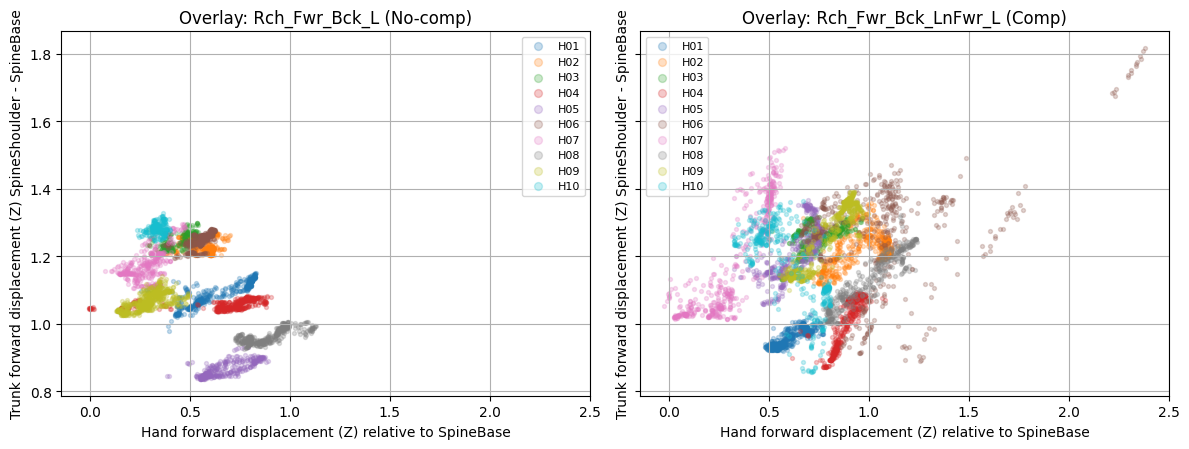

In [18]:
# === EDA 3: Phase Plot (All Subjects): same exercise, no-comp vs lean-forward, overlay per condition ===
# Goal: For a chosen pair of tasks (e.g., Rch_Fwr_Bck_L vs Rch_Fwr_Bck_LnFwr_L),
# overlay ALL subjects who have BOTH folders, to check if the same kinematic pattern holds.
# ----------------------------
# USER SETTINGS
# ----------------------------
TASK_NO_COMP = "Rch_Fwr_Bck_L"
TASK_COMP    = "Rch_Fwr_Bck_LnFwr_L"   # change to ShElev/TrRot variants as needed

# Use both groups by default (Hxx and Pxx)
INCLUDE_PREFIXES = ("H", "P")

# Optional: downsample frames per subject to reduce overplotting (None to disable)
MAX_POINTS_PER_SUBJECT = 1500

# ----------------------------
# JOINT SET (original Kinect indices): torso + both arms
# ----------------------------
KEEP_JOINTS = np.array([
    0, 1, 20, 2, 3,        # SpineBase, SpineMid, SpineShoulder, Neck, Head
    4, 5, 6, 7, 21, 22,    # Left arm
    8, 9, 10, 11, 23, 24   # Right arm
], dtype=int)

def select_joints_blocked_layout(X, keep_joints):
    if X.ndim != 2 or (X.shape[1] % 3 != 0):
        raise ValueError(f"Expected X shape (N, 3*J). Got {X.shape}")
    J = X.shape[1] // 3
    if keep_joints.max() >= J:
        raise ValueError(f"KEEP_JOINTS max={keep_joints.max()} but J={J}")
    Xblk = X[:, :J]
    Zblk = X[:, J:2*J]
    Yblk = X[:, 2*J:]
    return np.hstack([Xblk[:, keep_joints], Zblk[:, keep_joints], Yblk[:, keep_joints]])

def extract_blocked(X):
    J = X.shape[1] // 3
    return X[:, :J], X[:, J:2*J], X[:, 2*J:]

def load_task(subject, task):
    task_dir = DATA_DIR / subject / task
    jp = task_dir / "Joint_Positions.csv"
    lb = task_dir / "Labels.csv"
    if not (jp.exists() and lb.exists()):
        return None, None
    X = load_joint_positions_csv(jp, task)
    y = load_labels_csv(lb).ravel().astype(int)
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Length mismatch in {subject}/{task}: X={X.shape[0]} vs y={y.shape[0]}")
    return X, y

def list_subjects_with_both_tasks(data_dir: Path, t1: str, t2: str):
    subs = []
    for p in sorted([p for p in data_dir.iterdir() if p.is_dir()]):
        if not p.name.startswith(INCLUDE_PREFIXES):
            continue
        if (p / t1).is_dir() and (p / t2).is_dir():
            # also ensure files exist in both folders
            ok1 = (p / t1 / "Joint_Positions.csv").exists() and (p / t1 / "Labels.csv").exists()
            ok2 = (p / t2 / "Joint_Positions.csv").exists() and (p / t2 / "Labels.csv").exists()
            if ok1 and ok2:
                subs.append(p.name)
    return subs

# ----------------------------
# Determine hand joint index in REDUCED joint list
# After KEEP_JOINTS, reduced indices:
# 0:SpineBase, 2:SpineShoulder, 8:HandLeft, 14:HandRight
# ----------------------------
SPINE_BASE = 0
SPINE_SHOULDER = 2
HAND = 8 if TASK_NO_COMP.endswith("_L") else 14

# ----------------------------
# Collect all subjects that have BOTH tasks
# ----------------------------
subjects_ok = list_subjects_with_both_tasks(DATA_DIR, TASK_NO_COMP, TASK_COMP)
print(f"Subjects with BOTH '{TASK_NO_COMP}' and '{TASK_COMP}': {len(subjects_ok)}")
print(subjects_ok)

if len(subjects_ok) == 0:
    raise RuntimeError("No subjects found with both tasks. Check task folder names.")

# ----------------------------
# Plot overlay
# ----------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 4.6), sharex=True, sharey=True)

# left: no-comp overlay
axs[0].set_title(f"Overlay: {TASK_NO_COMP} (No-comp)")
# right: comp overlay
axs[1].set_title(f"Overlay: {TASK_COMP} (Comp)")

rng = np.random.default_rng(42)

for sub in subjects_ok:
    # Load both tasks
    X_nc_raw, _ = load_task(sub, TASK_NO_COMP)
    X_c_raw,  _ = load_task(sub, TASK_COMP)

    if X_nc_raw is None or X_c_raw is None:
        continue

    # Reduce joints
    X_nc = select_joints_blocked_layout(X_nc_raw, KEEP_JOINTS)
    X_c  = select_joints_blocked_layout(X_c_raw,  KEEP_JOINTS)

    # Extract Z blocks
    _, Z_nc, _ = extract_blocked(X_nc)
    _, Z_c,  _ = extract_blocked(X_c)

    # Phase variables
    hand_nc  = Z_nc[:, HAND] - Z_nc[:, SPINE_BASE]
    trunk_nc = Z_nc[:, SPINE_SHOULDER] - Z_nc[:, SPINE_BASE]

    hand_c   = Z_c[:, HAND] - Z_c[:, SPINE_BASE]
    trunk_c  = Z_c[:, SPINE_SHOULDER] - Z_c[:, SPINE_BASE]

    # Optional downsample for readability
    if MAX_POINTS_PER_SUBJECT is not None:
        if len(hand_nc) > MAX_POINTS_PER_SUBJECT:
            idx = rng.choice(len(hand_nc), size=MAX_POINTS_PER_SUBJECT, replace=False)
            hand_nc, trunk_nc = hand_nc[idx], trunk_nc[idx]
        if len(hand_c) > MAX_POINTS_PER_SUBJECT:
            idx = rng.choice(len(hand_c), size=MAX_POINTS_PER_SUBJECT, replace=False)
            hand_c, trunk_c = hand_c[idx], trunk_c[idx]

    # Plot both conditions (no explicit colors; matplotlib will cycle per subject)
    axs[0].scatter(hand_nc, trunk_nc, s=8, alpha=0.25, label=sub)
    axs[1].scatter(hand_c,  trunk_c,  s=8, alpha=0.25, label=sub)

# Axis labels and grid
for ax in axs:
    ax.set_xlabel("Hand forward displacement (Z) relative to SpineBase")
    ax.set_ylabel("Trunk forward displacement (Z) SpineShoulder - SpineBase")
    ax.grid(True)

# Legend handling: too many subjects will clutter; show only if <= 12
if len(subjects_ok) <= 12:
    axs[0].legend(markerscale=2, fontsize=8, loc="best")
    axs[1].legend(markerscale=2, fontsize=8, loc="best")
else:
    print("Legend suppressed (too many subjects). Consider filtering subjects or reducing INCLUDE_PREFIXES.")

plt.tight_layout()
plt.show()


## Classification


In [19]:
# === CLASSIFICATION BASELINE (Binary): Compensation vs No-compensation ===
# - Subject-independent evaluation using GroupKFold (no subject leakage)
# - Proper scaling (fit on train only)
# - Strong baselines: Logistic Regression + Linear SVM
#
# Assumes you already have:
#   H_data_rc, P_data_rc  -> (N, 51) root-centered
#   H_labels, P_labels    -> (N, 1) original labels (1=no-comp, 2/3/4/other=comp)
#   H_sub_ids, P_sub_ids  -> (N,) subject IDs like "H01", "P03"

# ----------------------------
# 1) Build X, y, groups
# ----------------------------
X = np.vstack([H_data_rc, P_data_rc])

y_raw = np.vstack([H_labels, P_labels]).ravel().astype(int)

# Binary target: 0 = no-comp (label 1), 1 = compensatory (everything else)
y = (y_raw != 1).astype(int)

groups = np.concatenate([H_sub_ids, P_sub_ids])

print("X:", X.shape, "y:", y.shape, "groups:", groups.shape)
print("Unique subjects:", np.unique(groups).size)
print("Binary label counts:", np.bincount(y))

# ----------------------------
# 2) Define models (scaled, cost-sensitive)
# ----------------------------
models = {
    "LogReg(L2,balanced)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "LinearSVM(balanced)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(class_weight="balanced", dual="auto"))
    ])
}

# ----------------------------
# 3) Subject-independent CV
# ----------------------------
gkf = GroupKFold(n_splits=5)

results = {}
for name, model in models.items():
    y_true_all, y_pred_all, y_score_all = [], [], []

    for fold, (tr, te) in enumerate(gkf.split(X, y, groups=groups), start=1):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]

        model.fit(X_tr, y_tr)

        # hard predictions
        y_pred = model.predict(X_te)

        # scores for ROC
        clf = model.named_steps["clf"] if hasattr(model, "named_steps") else model
        if hasattr(clf, "predict_proba"):
            y_score = model.predict_proba(X_te)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_score = model.decision_function(X_te)
        else:
            raise RuntimeError(f"{name} has neither predict_proba nor decision_function for ROC.")

        y_true_all.append(y_te)
        y_pred_all.append(y_pred)
        y_score_all.append(y_score)

        bacc = balanced_accuracy_score(y_te, y_pred)
        print(f"[{name}] fold {fold}: balanced_acc={bacc:.3f} | "
              f"test_subjects={np.unique(groups[te]).tolist()}")

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)
    y_score_all = np.concatenate(y_score_all)

    results[name] = {
        "y_true": y_true_all,
        "y_pred": y_pred_all,
        "y_score": y_score_all,
        "balanced_acc": balanced_accuracy_score(y_true_all, y_pred_all),
        "confusion": confusion_matrix(y_true_all, y_pred_all),
        "report": classification_report(y_true_all, y_pred_all, digits=4),
    }

# Print aggregate results (same as you had)
for name, res in results.items():
    print("\n" + "="*70)
    print(name)
    print("Balanced accuracy:", f"{res['balanced_acc']:.4f}")
    print("Confusion matrix (rows=true, cols=pred) [0=no-comp, 1=comp]:\n", res["confusion"])
    print(res["report"])

X: (70845, 51) y: (70845,) groups: (70845,)
Unique subjects: 19
Binary label counts: [51800 19045]
[LogReg(L2,balanced)] fold 1: balanced_acc=0.731 | test_subjects=['H09', 'H10', 'P05']
[LogReg(L2,balanced)] fold 2: balanced_acc=0.804 | test_subjects=['H01', 'H03', 'P02', 'P08']
[LogReg(L2,balanced)] fold 3: balanced_acc=0.748 | test_subjects=['H07', 'H08', 'P06', 'P09']
[LogReg(L2,balanced)] fold 4: balanced_acc=0.743 | test_subjects=['H05', 'H06', 'P04', 'P07']
[LogReg(L2,balanced)] fold 5: balanced_acc=0.806 | test_subjects=['H02', 'H04', 'P01', 'P03']
[LinearSVM(balanced)] fold 1: balanced_acc=0.736 | test_subjects=['H09', 'H10', 'P05']
[LinearSVM(balanced)] fold 2: balanced_acc=0.813 | test_subjects=['H01', 'H03', 'P02', 'P08']
[LinearSVM(balanced)] fold 3: balanced_acc=0.743 | test_subjects=['H07', 'H08', 'P06', 'P09']
[LinearSVM(balanced)] fold 4: balanced_acc=0.748 | test_subjects=['H05', 'H06', 'P04', 'P07']
[LinearSVM(balanced)] fold 5: balanced_acc=0.807 | test_subjects=['H0

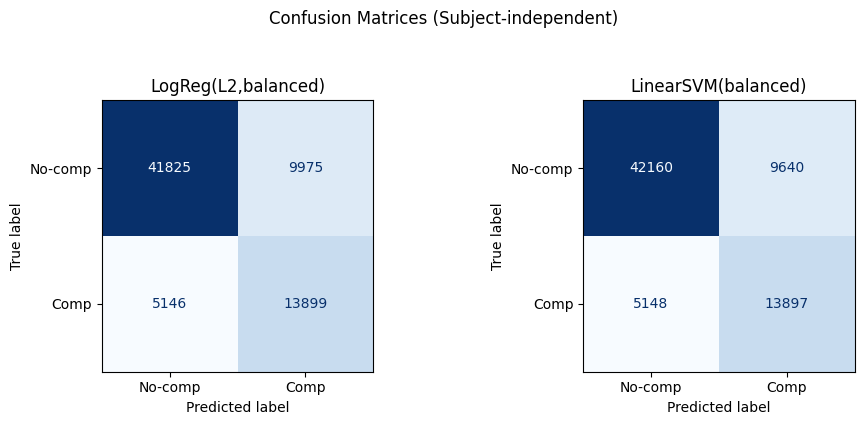

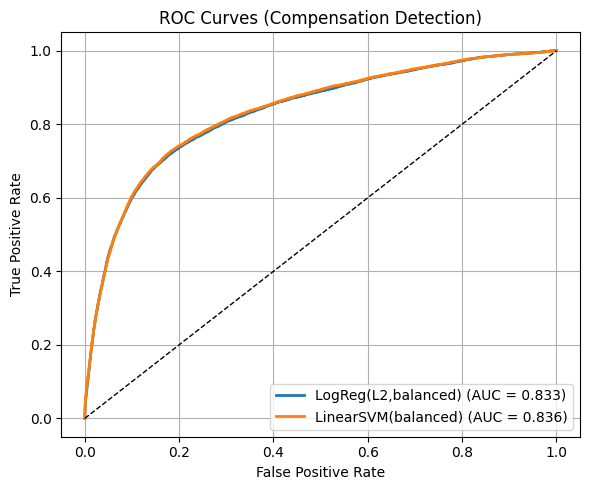

In [20]:
# --- side-by-side confusion matrices ---
fig, axs = plt.subplots(1, len(results), figsize=(10, 4))

if len(results) == 1:
    axs = [axs]

for ax, (name, res) in zip(axs, results.items()):
    ConfusionMatrixDisplay.from_predictions(
        res["y_true"], res["y_pred"],
        display_labels=["No-comp", "Comp"],
        cmap="Blues",
        ax=ax,
        colorbar=False
    )
    ax.set_title(name)

plt.suptitle("Confusion Matrices (Subject-independent)", y=1.05)
plt.tight_layout()
plt.show()

# --- ROC curves (same figure) ---
plt.figure(figsize=(6, 5))

for name, res in results.items():
    fpr, tpr, _ = roc_curve(res["y_true"], res["y_score"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Compensation Detection)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Clustering


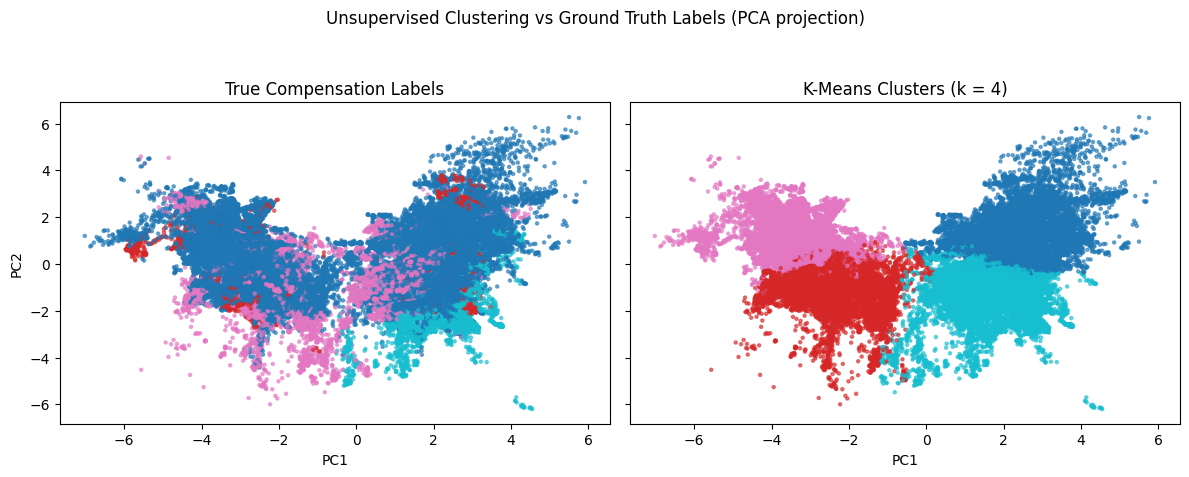

In [21]:
# === UNSUPERVISED CLUSTERING vs TRUE LABELS (PCA VISUALIZATION) ===

# -------------------------------------------------
# INPUTS (already exist in your notebook)
# -------------------------------------------------
# Use either:
# X = root-centered + joint-reduced data (51D)
# or original full data (75D)
X = np.vstack([H_data, P_data])      # shape: (N, D)
y_true = np.vstack([H_labels, P_labels]).astype(int).ravel()  # 1–4 labels

# -------------------------------------------------
# PCA (for visualization only)
# -------------------------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# -------------------------------------------------
# K-Means clustering (k = 4)
# -------------------------------------------------
kmeans = KMeans(n_clusters=4, n_init=20, random_state=42)
y_cluster = kmeans.fit_predict(X)

# -------------------------------------------------
# PLOT: side-by-side comparison
# -------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True, sharey=True)

# --- True labels ---
scatter1 = axs[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y_true, s=5, cmap="tab10", alpha=0.6
)
axs[0].set_title("True Compensation Labels")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

# --- Cluster labels ---
scatter2 = axs[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y_cluster, s=5, cmap="tab10", alpha=0.6
)
axs[1].set_title("K-Means Clusters (k = 4)")
axs[1].set_xlabel("PC1")

plt.suptitle("Unsupervised Clustering vs Ground Truth Labels (PCA projection)", y=1.05)
plt.tight_layout()
plt.show()


In [22]:
# === SILHOUETTE SCORE FOR UNSUPERVISED CLUSTERING ===
# -------------------------------------------------
# Input data (already prepared earlier)
# Use the same feature matrix used for clustering
# -------------------------------------------------
X_cluster = X.copy()   # shape: (N, D), e.g. 51D or 75D

# Standardize (important for K-means + silhouette)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# -------------------------------------------------
# K-means clustering
# -------------------------------------------------
kmeans = KMeans(n_clusters=4, n_init=20, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# -------------------------------------------------
# Silhouette score
# -------------------------------------------------
sil_score = silhouette_score(X_scaled, cluster_labels)

print(f"Silhouette score (k=4): {sil_score:.4f}")


Silhouette score (k=4): 0.1848
